# Group Project - AI for Security

**Members:**
- Andrea Ferrazzano - andrea1.ferrazzano@mail.polimi.it - 10703279
- Marco Gorini - marco2.gorini@mail.polimi.it - 10710545
- Leonardo Saveri - leonardo.saveri@mail.polimi.it - 10745545
- Claudia Pierpaoli - claudia.pierpaoli@mail.polimi.it - 11016822

# Objective:
In this section of the project, we will train ensemble classifiers.

In [1]:
!pip3 install xgboost

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3.9 -m pip install --upgrade pip' command.


## Imports

In [18]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os
from joblib import dump, load
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance
from sklearn.neural_network import MLPClassifier

import time
from sklearn.metrics import (
    accuracy_score, 
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    average_precision_score,
    roc_curve,
    roc_auc_score
)
from sklearn.calibration import CalibrationDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [3]:
df_train = pd.read_csv("data/df_train.csv")
df_test = pd.read_csv("data/df_test.csv")

print(df_train.shape)
df_test.shape

(55749, 32)


(16000, 32)

In [4]:
df_train.columns

Index(['flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate',
       'fin_flag_number', 'syn_flag_number', 'rst_flag_number',
       'psh_flag_number', 'ack_flag_number', 'ack_count', 'syn_count',
       'fin_count', 'urg_count', 'rst_count', 'HTTP', 'HTTPS', 'SSH', 'TCP',
       'UDP', 'ICMP', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT',
       'Covariance', 'Variance', 'label', 'category_label'],
      dtype='object')

In [5]:
X_train = df_train.drop(columns=["label", "category_label"])
X_test = df_test.drop(columns=["label", "category_label"])

y_train = df_train["category_label"]
y_test = df_test["category_label"]

Now we are scaling values in the train and the test set (everything in this case, because there are only numerical features) to have better performances and predictions.

In [6]:
standard_scaler = StandardScaler().fit(X_train)

X_train = standard_scaler.transform(X_train)
X_test = standard_scaler.transform(X_test)

Let's save the standars scaler also for the future

In [7]:
dump(standard_scaler, "scalers/standard_scaler.bin", compress=True)

['scalers/standard_scaler.bin']

In [8]:
X_train

array([[-0.36801019, -0.35346166,  0.46054157, ..., -0.01018213,
        -0.35051081, -1.27017796],
       [-0.36888444, -0.38354661, -0.52506693, ..., -0.01058209,
        -0.35051081, -1.27017796],
       [-0.36888444, -0.38354661, -0.52506693, ..., -0.00643102,
        -0.35051081, -1.27017796],
       ...,
       [ 0.36874052, -0.37683062, -0.33690531, ...,  1.26147349,
        -0.34579192,  0.99974844],
       [-0.11088783, -0.32960377, -0.52506693, ...,  1.2614745 ,
         1.57512056,  0.99974844],
       [ 0.73144974, -0.33881354, -0.22938438, ..., -1.27568763,
        -0.34866664,  0.7727558 ]])

In [9]:
X_test

array([[-0.3594684 ,  3.34878602, -0.52506693, ...,  1.26151154,
         3.37066307,  0.99974844],
       [-0.33873717, -0.38126271,  0.46054157, ..., -1.27568763,
        -0.3451429 ,  0.7727558 ],
       [-0.36784072, -0.38318251, -0.52506693, ..., -1.27568763,
        -0.35007724,  0.7727558 ],
       ...,
       [ 0.53284477, -0.34475238, -0.47130647, ...,  1.26163369,
        -0.34559026,  0.99974844],
       [ 0.09184591, -0.32815799,  0.26341987, ..., -1.27568763,
        -0.34286041,  0.7727558 ],
       [-0.36888444, -0.38354661, -0.52506693, ..., -0.00644665,
        -0.35051081, -1.27017796]])

In [10]:
label2id = {'BenignTraffic': 0, 'Mirai': 1, 'DDoS': 2, 'Spoofing': 3, 'Web': 4, 'Recon': 5, 'BruteForce': 6, 'DoS': 7}
id2label = {0: 'BenignTraffic', 1: 'Mirai', 2: 'DDoS', 3: 'Spoofing', 4: 'Web', 5: 'Recon', 6: 'BruteForce', 7: 'DoS'}
y_train = [label2id[label] for label in y_train]
y_test = [label2id[label] for label in y_test]

# Let's prepare also the final test we will use with each best classifier

In [11]:
df_test_final = pd.read_csv("data/final_test_data.csv")
df_test_final = df_test_final[df_train.columns]

X_test_final = df_test_final.drop(columns=["label", "category_label"])
y_test_final = df_test_final["category_label"]

X_test_final = standard_scaler.transform(X_test_final)
y_test_final = [label2id[label] for label in y_test_final]

In [12]:
X_test_final

array([[-0.36888444, -0.38354661, -0.52506693, ..., -0.00637693,
        -0.35051081, -1.27017796],
       [-0.36858791, -0.35326693,  0.46054157, ..., -0.01005686,
        -0.35051081, -1.27017796],
       [-0.3686571 , -0.36995928,  0.46054157, ..., -0.01019597,
        -0.35049261, -1.15668164],
       ...,
       [ 0.46692148, -0.34883984, -0.13082353, ...,  1.26109575,
        -0.04195424,  0.99974844],
       [-0.36870301, -0.3834317 , -0.417546  , ...,  1.26147301,
        -0.34580619,  0.99974844],
       [-0.10955779, -0.31405063, -0.48922662, ...,  1.26147385,
        -0.3486514 ,  0.99974844]])

In [13]:
df_train.columns

Index(['flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate',
       'fin_flag_number', 'syn_flag_number', 'rst_flag_number',
       'psh_flag_number', 'ack_flag_number', 'ack_count', 'syn_count',
       'fin_count', 'urg_count', 'rst_count', 'HTTP', 'HTTPS', 'SSH', 'TCP',
       'UDP', 'ICMP', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT',
       'Covariance', 'Variance', 'label', 'category_label'],
      dtype='object')

<Axes: >

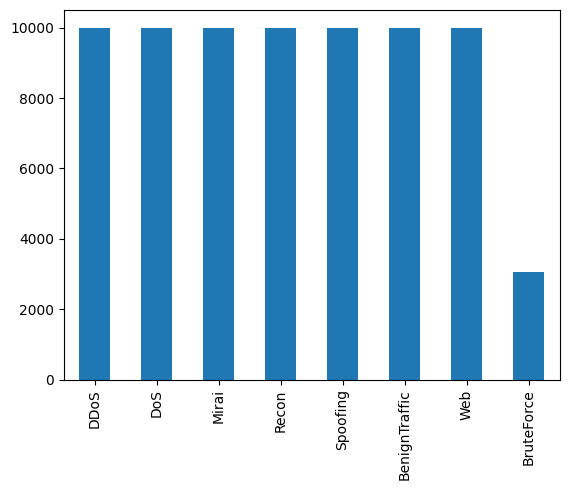

In [14]:
df_test_final.category_label.value_counts().plot(kind='bar')

# ENSEMBLE CLASSIFIERS

### Helper Function

In [37]:
def plot_metric(eval_dict, model_name, param_name, param_values, log_scale=False):
    fig, ax = plt.subplots(3, 2, figsize=(12, 8), sharex=True)

    metrics = {
        'Accuracy': 'list_accuracy',
        'Precision': 'list_precision',
        'Recall': 'list_recall',
        'Specificity': 'list_specificity',
        'F1': 'list_f1',
        'Training time': 'list_training_time'
    }

    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:olive', 'tab:cyan', 'tab:red']

    for i, (metric_name, metric_key) in enumerate(metrics.items()):
        x_value = list(range(0, len(eval_dict[metric_key])))
        ax[i // 2, i % 2].plot(x_value, eval_dict[metric_key], c=colors[i])
        if log_scale:
            ax[i // 2, i % 2].set_xscale('log')
        
        # Add xticks at the position of the maximum value
        max_idx = np.argmax(eval_dict[metric_key])
        max_value = eval_dict[metric_key][max_idx]
        ax[i // 2, i % 2].axvline(x=x_value[max_idx], color='lightgray', linestyle='--')
        ax[i // 2, i % 2].axhline(y=max_value, color='lightgray', linestyle='--')
        ax[i // 2, i % 2].scatter(x_value[max_idx], max_value, color='red', marker='o')
        ax[i // 2, i % 2].set_xticks(ticks=x_value, labels=param_values, rotation=90)
        
        ax[i // 2, i % 2].set_title(f'{metric_name} ({model_name})')
        ax[i // 2, i % 2].set_xlabel(param_name)
        
        # Add y-axis label (tick) for the maximum value
        ax[i // 2, i % 2].set_ylabel(metric_name)
        yticks = list(ax[i // 2, i % 2].get_yticks())
        del yticks[-2:]
        yticks.append(max_value)
        ax[i // 2, i % 2].set_yticks(yticks)
        if metric_name != 'Training time':
            ax[i // 2, i % 2].text(max_idx, eval_dict[metric_key][np.argmin(eval_dict[metric_key])], f'{param_values[max_idx]}', c='red')
        
    plt.tight_layout()
    plt.show()


## XGBoost

For XGBoost, the parameter we are considering is the number of estimators- which are the number of trees.

In [16]:
list_estimators = range(1, 200, 5)

In [17]:
eval_dict = {'list_accuracy': [], 
             'list_precision': [], 
             'list_recall': [], 
             'list_specificity': [], 
             'list_f1': [], 
             'list_training_time': []}

In [18]:
best_accuracy = 0.0

for val in list_estimators:
    # Create classifier instance
    clf = XGBClassifier(n_estimators=val, n_jobs=-1, random_state=777)
    
    # Register start time
    t_start = time.time()
    
    # Fit the classifier on the training data
    clf.fit(X_train, y_train)
    
    # Register end time
    t_stop = time.time()
    
    # Predict probabilities on the test data
    y_pred = clf.predict(X_test)
    
    # Calculate accuracy
    current_accuracy = accuracy_score(y_test, y_pred)
    
    # Save the model if it has the best accuracy so far
    if current_accuracy > best_accuracy:
        best_accuracy = current_accuracy
        dump(clf, 'models/ensemble/xgb_best.joblib')

    eval_dict['list_accuracy'].append(current_accuracy)
    eval_dict['list_precision'].append(precision_score(y_test, y_pred, average='weighted'))
    eval_dict['list_recall'].append(recall_score(y_test, y_pred, average='weighted'))
    eval_dict['list_specificity'].append(recall_score(y_test, y_pred, pos_label=0, average='weighted'))
    eval_dict['list_f1'].append(f1_score(y_test, y_pred, average='weighted'))
    eval_dict['list_training_time'].append(t_stop - t_start)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_cl

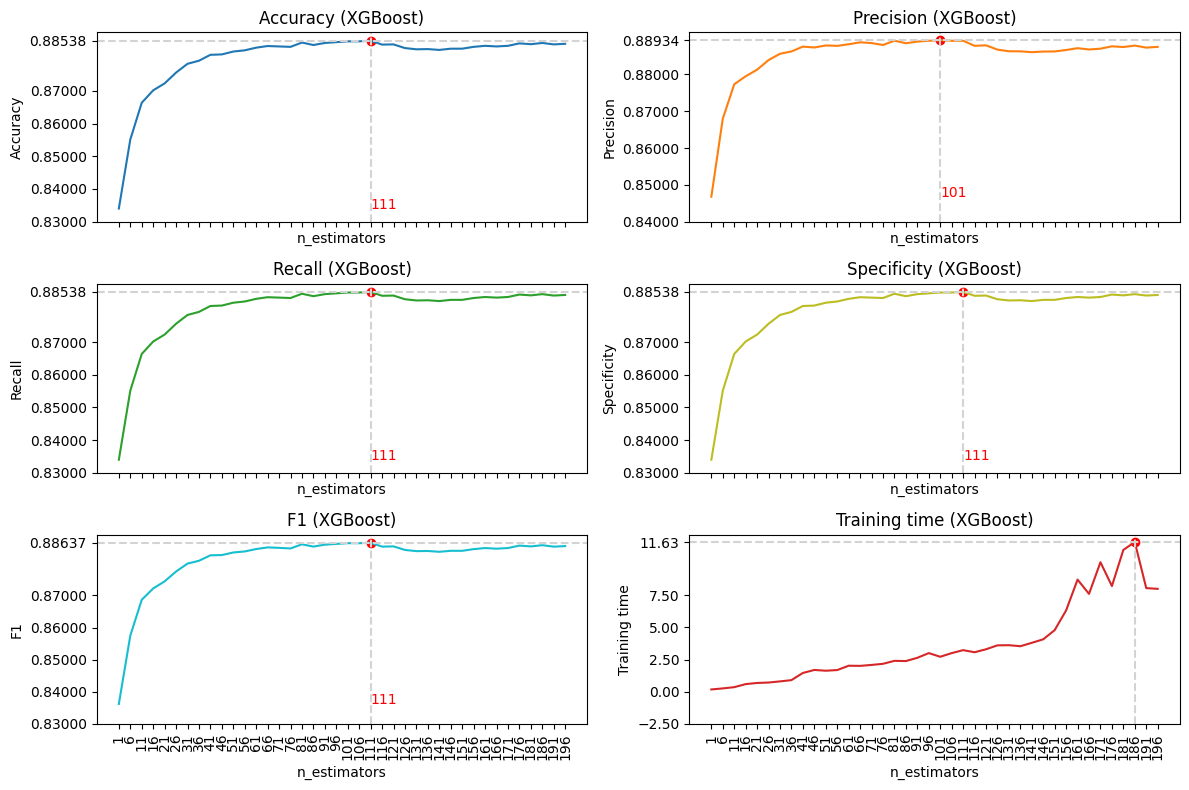

In [19]:
plot_metric(eval_dict, 'XGBoost', 'n_estimators', list_estimators)

Overall, the model performance tends to reach an optimal performance with 111 estimators (except for precision, which has 101 estimators)

In [42]:
clf = load('models/ensemble/xgb_best.joblib')
y_pred = clf.predict(X_test_final)

In [43]:
print(classification_report(y_test_final, y_pred, target_names=label2id.keys()))

               precision    recall  f1-score   support

BenignTraffic       0.87      0.88      0.88     10000
        Mirai       1.00      0.98      0.99     10000
         DDoS       1.00      0.96      0.98     10000
     Spoofing       0.87      0.83      0.85     10000
          Web       0.78      0.87      0.82     10000
        Recon       0.86      0.78      0.82     10000
   BruteForce       0.60      0.81      0.69      3064
          DoS       1.00      0.97      0.98     10000

     accuracy                           0.89     73064
    macro avg       0.87      0.88      0.88     73064
 weighted avg       0.90      0.89      0.89     73064



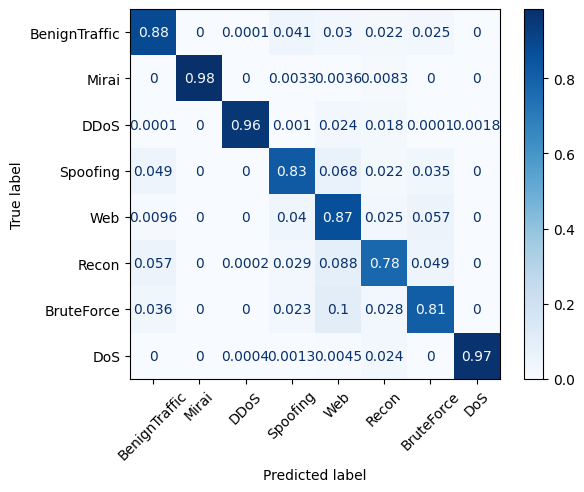

In [44]:
ConfusionMatrixDisplay.from_predictions(y_test_final, y_pred, display_labels=label2id, cmap='Blues', normalize='true', xticks_rotation=45)
plt.show()

Let's try some features selection

In [33]:
feature_names = df_train.drop(columns=["label", "category_label"]).columns
feature_importance = clf.feature_importances_
feature_importance_dict = dict(zip(feature_names, feature_importance))
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1])

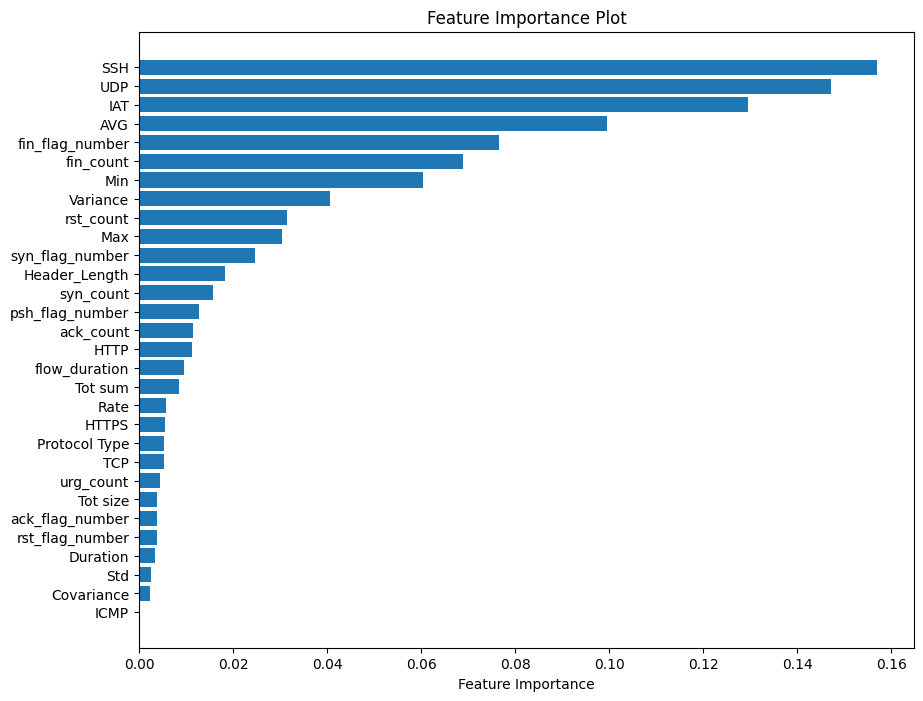

In [34]:
feature_names, importance_values = zip(*sorted_features)

plt.figure(figsize=(10, 8))
plt.barh(range(len(feature_names)), importance_values, align='center')
plt.yticks(range(len(feature_names)), feature_names)
plt.xlabel('Feature Importance')
plt.title('Feature Importance Plot')
plt.show()

XGBoost gives importance to certain features by selecting the most relevant ones. What is important to notice is the threshold value can be chosen arbitrarily, it just is a matter of how complex you want the complexity of analysis to be. We decided to set the threshold as feature importance= 0.05.


In [35]:
important_features = [feature for feature, importance in sorted_features if importance >= 0.05]

In [36]:
important_features

['Min', 'fin_count', 'fin_flag_number', 'AVG', 'IAT', 'UDP', 'SSH']

In [45]:
list_estimators = range(1, 200, 10)

In [46]:
eval_dict = {'list_accuracy': [], 
             'list_precision': [], 
             'list_recall': [], 
             'list_specificity': [], 
             'list_f1': [], 
             'list_training_time': []}

In [47]:
X_train_xgb_important = df_train[important_features]
X_test_xgb_important = df_test[important_features]
X_train_xgb_important = standard_scaler.fit_transform(X_train_xgb_important)
X_test_xgb_important = standard_scaler.transform(X_test_xgb_important)

In [48]:
best_accuracy = 0.0

for val in list_estimators:
    # Create classifier instance
    clf = XGBClassifier(n_estimators=val, n_jobs=-1, random_state=777)
    
    # Register start time
    t_start = time.time()
    
    # Fit the classifier on the training data
    clf.fit(X_train_xgb_important, y_train)
    
    # Register end time
    t_stop = time.time()
    
    # Predict probabilities on the test data
    y_pred = clf.predict(X_test_xgb_important)
    
    # Calculate accuracy
    current_accuracy = accuracy_score(y_test, y_pred)
    
    # Save the model if it has the best accuracy so far
    if current_accuracy > best_accuracy:
        best_accuracy = current_accuracy
        dump(clf, 'models/ensemble/xgb_best_feature_importance_05.joblib')

    eval_dict['list_accuracy'].append(current_accuracy)
    eval_dict['list_precision'].append(precision_score(y_test, y_pred, average='weighted'))
    eval_dict['list_recall'].append(recall_score(y_test, y_pred, average='weighted'))
    eval_dict['list_specificity'].append(recall_score(y_test, y_pred, pos_label=0, average='weighted'))
    eval_dict['list_f1'].append(f1_score(y_test, y_pred, average='weighted'))
    eval_dict['list_training_time'].append(t_stop - t_start)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_cl

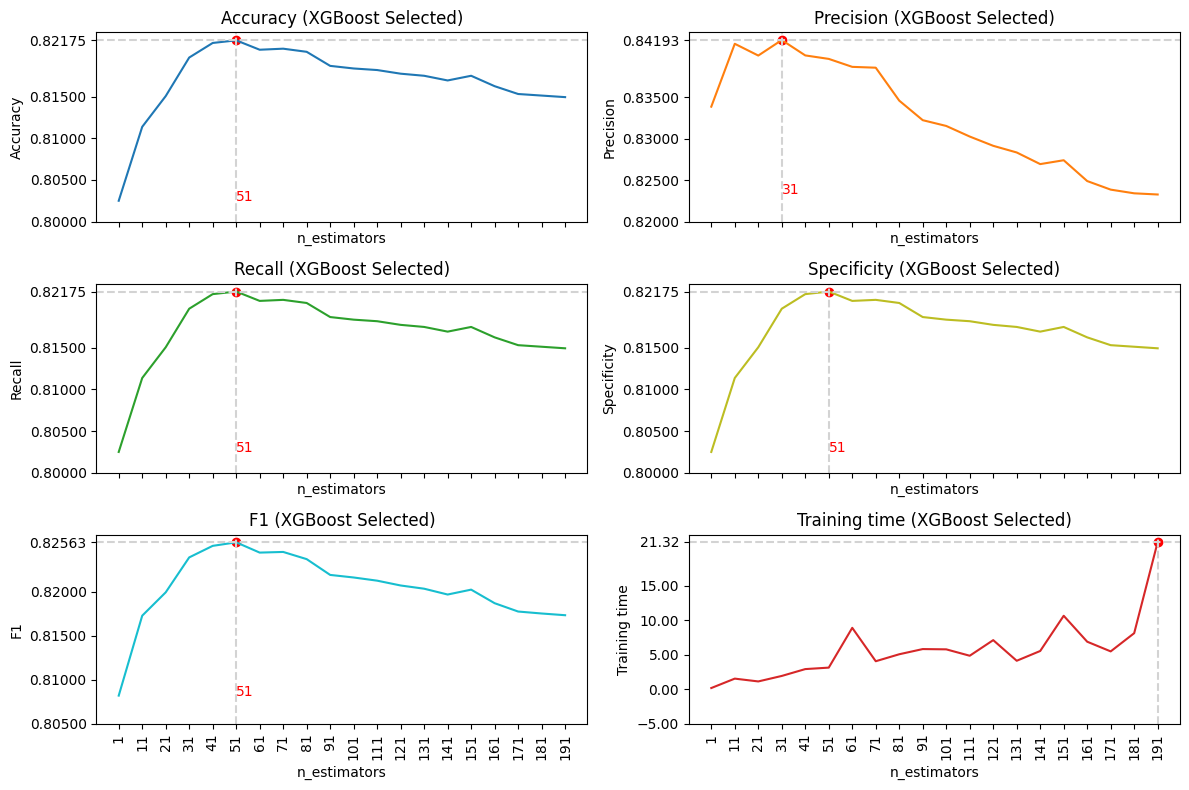

In [49]:
plot_metric(eval_dict, 'XGBoost Selected', 'n_estimators', list_estimators)

Compared to before, the optimal number of estimators selected are 51 (as opposed to 111). We can see that the performance is much worse with this threshold, let's try with a smaller one.

In [50]:
important_features = [feature for feature, importance in sorted_features if importance >= 0.02]

In [51]:
important_features

['syn_flag_number',
 'Max',
 'rst_count',
 'Variance',
 'Min',
 'fin_count',
 'fin_flag_number',
 'AVG',
 'IAT',
 'UDP',
 'SSH']

In [52]:
list_estimators = range(1, 200, 10)

In [53]:
eval_dict = {'list_accuracy': [], 
             'list_precision': [], 
             'list_recall': [], 
             'list_specificity': [], 
             'list_f1': [], 
             'list_training_time': []}

In [54]:
X_train_xgb_important = df_train[important_features]
X_test_xgb_important = df_test[important_features]
X_train_xgb_important = standard_scaler.fit_transform(X_train_xgb_important)
X_test_xgb_important = standard_scaler.transform(X_test_xgb_important)

In [55]:
best_accuracy = 0.0

for val in list_estimators:
    # Create classifier instance
    clf = XGBClassifier(n_estimators=val, n_jobs=-1, random_state=777)
    
    # Register start time
    t_start = time.time()
    
    # Fit the classifier on the training data
    clf.fit(X_train_xgb_important, y_train)
    
    # Register end time
    t_stop = time.time()
    
    # Predict probabilities on the test data
    y_pred = clf.predict(X_test_xgb_important)
    
    # Calculate accuracy
    current_accuracy = accuracy_score(y_test, y_pred)
    
    # Save the model if it has the best accuracy so far
    if current_accuracy > best_accuracy:
        best_accuracy = current_accuracy
        dump(clf, 'models/ensemble/xgb_best_feature_importance_02.joblib')

    eval_dict['list_accuracy'].append(current_accuracy)
    eval_dict['list_precision'].append(precision_score(y_test, y_pred, average='weighted'))
    eval_dict['list_recall'].append(recall_score(y_test, y_pred, average='weighted'))
    eval_dict['list_specificity'].append(recall_score(y_test, y_pred, pos_label=0, average='weighted'))
    eval_dict['list_f1'].append(f1_score(y_test, y_pred, average='weighted'))
    eval_dict['list_training_time'].append(t_stop - t_start)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_cl

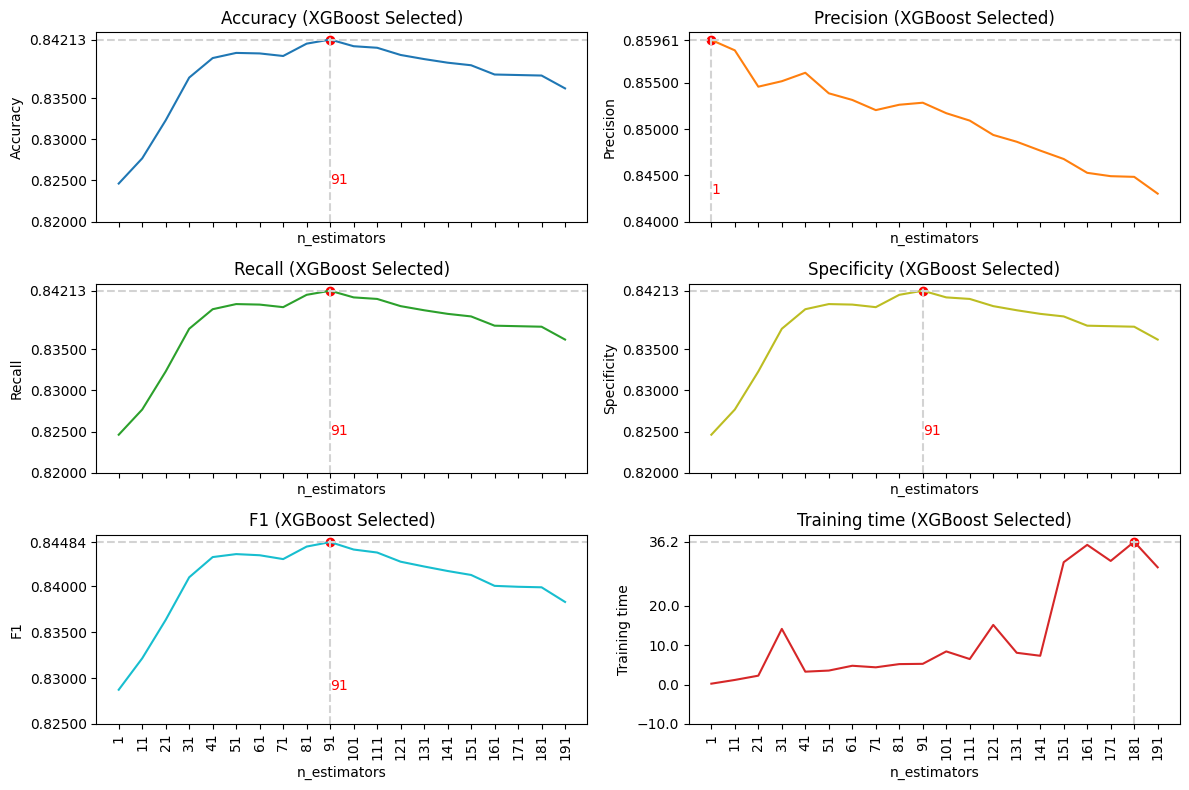

In [56]:
plot_metric(eval_dict, 'XGBoost Selected', 'n_estimators', list_estimators)

A little better, but still not nearly as good as the full one, because the full one doesn't take too long, we will consider that as better.

## Random Forests

For Random Forests, the parameter under consideration is the number of trees. 

In [22]:
list_estimators = range(1,200,5)

In [23]:
eval_dict = {'list_accuracy': [], 
             'list_precision': [], 
             'list_recall': [], 
             'list_specificity': [], 
             'list_f1': [], 
             'list_training_time': []}

In [24]:
best_accuracy = 0.0

for val in list_estimators:
    # Create classifier instance
    clf = RandomForestClassifier(n_estimators=val, n_jobs=-1, random_state=777)
    
    # Register start time
    t_start = time.time()
    
    # Fit the classifier on the training data
    clf.fit(X_train, y_train)
    
    # Register end time
    t_stop = time.time()
    
    # Predict probabilities on the test data
    y_pred = clf.predict(X_test)
    
    # Calculate accuracy
    current_accuracy = accuracy_score(y_test, y_pred)
    
    # Save the model if it has the best accuracy so far
    if current_accuracy > best_accuracy:
        best_accuracy = current_accuracy
        dump(clf, 'models/ensemble/RF_best.joblib')

    eval_dict['list_accuracy'].append(current_accuracy)
    eval_dict['list_precision'].append(precision_score(y_test, y_pred, average='weighted'))
    eval_dict['list_recall'].append(recall_score(y_test, y_pred, average='weighted'))
    eval_dict['list_specificity'].append(recall_score(y_test, y_pred, pos_label=0, average='weighted'))
    eval_dict['list_f1'].append(f1_score(y_test, y_pred, average='weighted'))
    eval_dict['list_training_time'].append(t_stop - t_start)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_cl

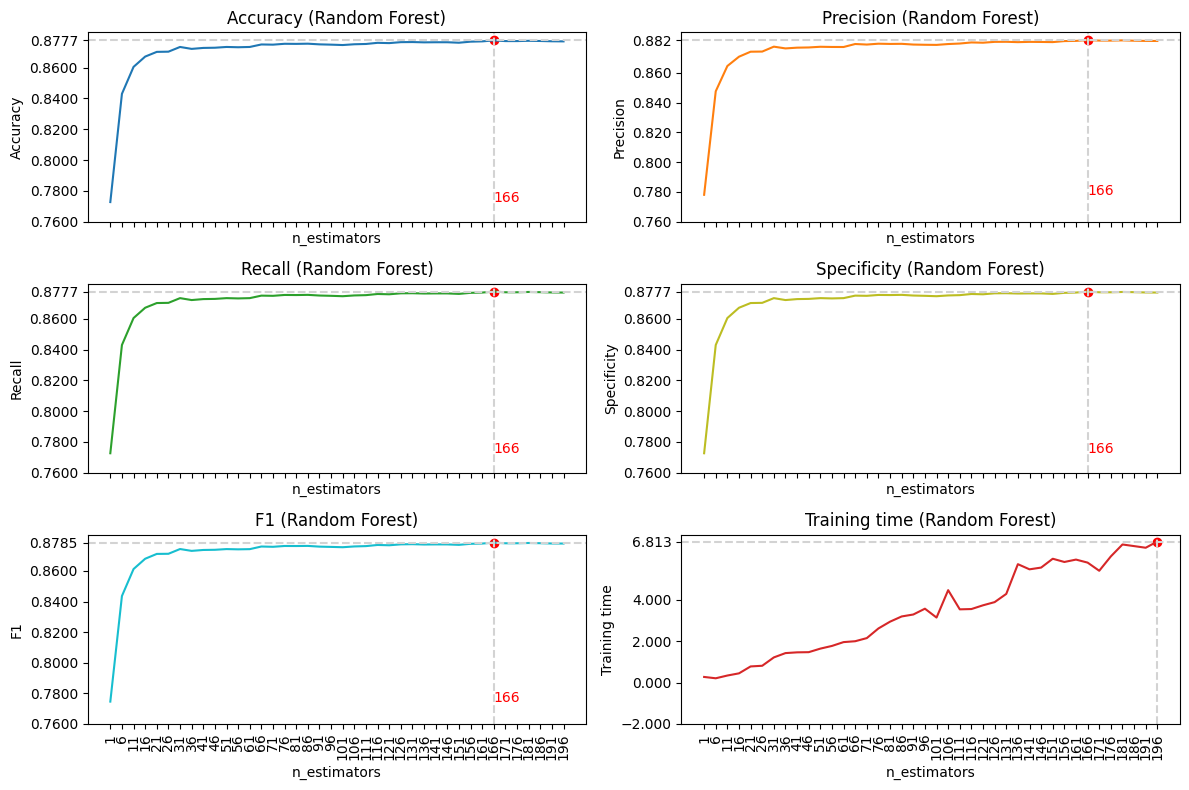

In [25]:
plot_metric(eval_dict, 'Random Forest', 'n_estimators', list_estimators)

With random forests, we found that the optimal parameter is 166 trees, higher than XGBoost. 

In [57]:
clf = load('models/ensemble/RF_best.joblib')
y_pred = clf.predict(X_test_final)

In [58]:
print(classification_report(y_test_final, y_pred, target_names=label2id))

               precision    recall  f1-score   support

BenignTraffic       0.86      0.86      0.86     10000
        Mirai       0.99      0.99      0.99     10000
         DDoS       1.00      0.96      0.98     10000
     Spoofing       0.83      0.81      0.82     10000
          Web       0.78      0.87      0.82     10000
        Recon       0.88      0.75      0.81     10000
   BruteForce       0.59      0.82      0.68      3064
          DoS       1.00      0.97      0.98     10000

     accuracy                           0.88     73064
    macro avg       0.87      0.88      0.87     73064
 weighted avg       0.89      0.88      0.89     73064



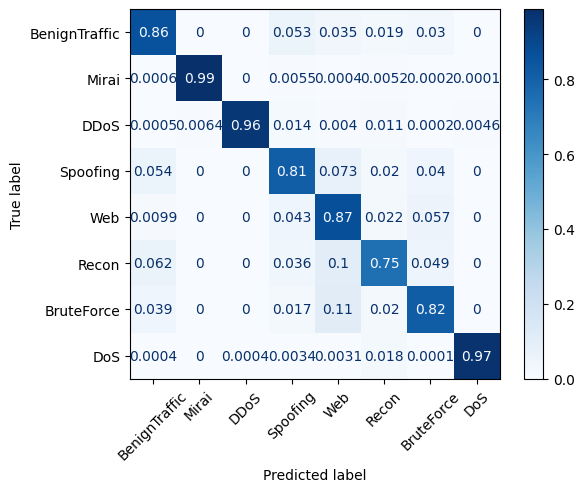

In [59]:
ConfusionMatrixDisplay.from_predictions(y_test_final, y_pred, display_labels=label2id, cmap='Blues', normalize='true', xticks_rotation=45)
plt.show()

The performances overall are the same, but we believe that XGBoost in our case is a slightly better choice, considering that it is more relevant for our analysis (its performance is .88 with respect to .86)

## Let's try to do some features selection

In [61]:
feature_names = df_train.drop(columns=["label", "category_label"]).columns
feature_importance = clf.feature_importances_
feature_importance_dict = dict(zip(feature_names, feature_importance))
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1])

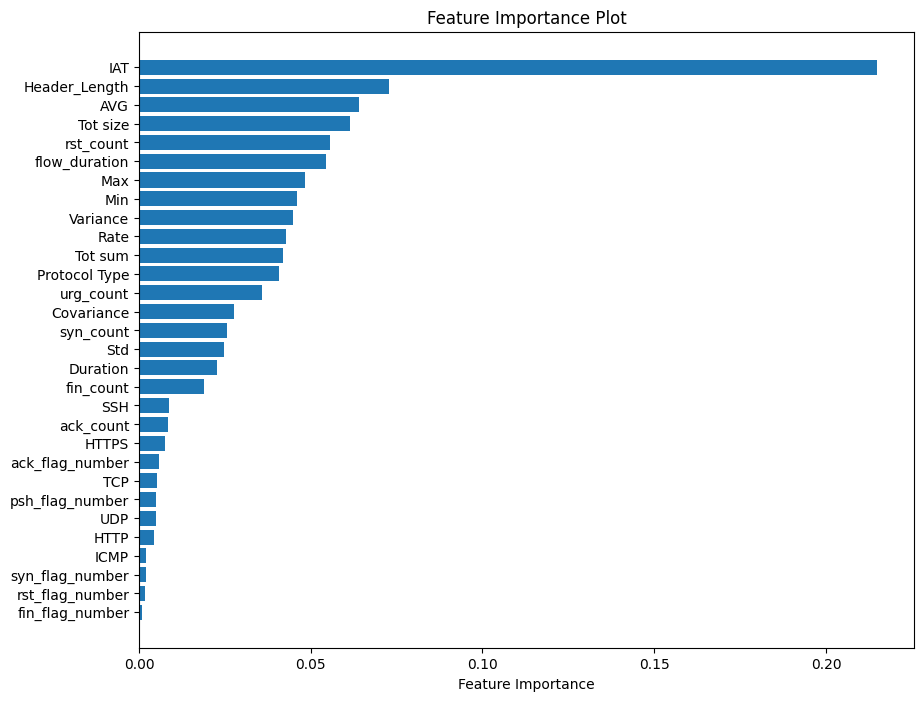

In [62]:
feature_names, importance_values = zip(*sorted_features)

plt.figure(figsize=(10, 8))
plt.barh(range(len(feature_names)), importance_values, align='center')
plt.yticks(range(len(feature_names)), feature_names)
plt.xlabel('Feature Importance')
plt.title('Feature Importance Plot')
plt.show()

In [72]:
important_features = [feature for feature, importance in sorted_features if importance >= 0.05]

In [73]:
important_features

['flow_duration', 'rst_count', 'Tot size', 'AVG', 'Header_Length', 'IAT']

In [74]:
list_estimators = range(1, 200, 10)

In [75]:
eval_dict = {'list_accuracy': [], 
             'list_precision': [], 
             'list_recall': [], 
             'list_specificity': [], 
             'list_f1': [], 
             'list_training_time': []}

In [76]:
X_train_rf_important = df_train[important_features]
X_test_rf_important = df_test[important_features]
X_train_rf_important = standard_scaler.fit_transform(X_train_rf_important)
X_test_rf_important = standard_scaler.transform(X_test_rf_important)

In [77]:
best_accuracy = 0.0

for val in list_estimators:
    # Create classifier instance
    clf = RandomForestClassifier(n_estimators=val, n_jobs=-1, random_state=777)
    
    # Register start time
    t_start = time.time()
    
    # Fit the classifier on the training data
    clf.fit(X_train_rf_important, y_train)
    
    # Register end time
    t_stop = time.time()
    
    # Predict probabilities on the test data
    y_pred = clf.predict(X_test_rf_important)
    
    # Calculate accuracy
    current_accuracy = accuracy_score(y_test, y_pred)
    
    # Save the model if it has the best accuracy so far
    if current_accuracy > best_accuracy:
        best_accuracy = current_accuracy
        dump(clf, 'models/ensemble/RF_best_feature_importance_05.joblib')

    eval_dict['list_accuracy'].append(current_accuracy)
    eval_dict['list_precision'].append(precision_score(y_test, y_pred, average='weighted'))
    eval_dict['list_recall'].append(recall_score(y_test, y_pred, average='weighted'))
    eval_dict['list_specificity'].append(recall_score(y_test, y_pred, pos_label=0, average='weighted'))
    eval_dict['list_f1'].append(f1_score(y_test, y_pred, average='weighted'))
    eval_dict['list_training_time'].append(t_stop - t_start)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_cl

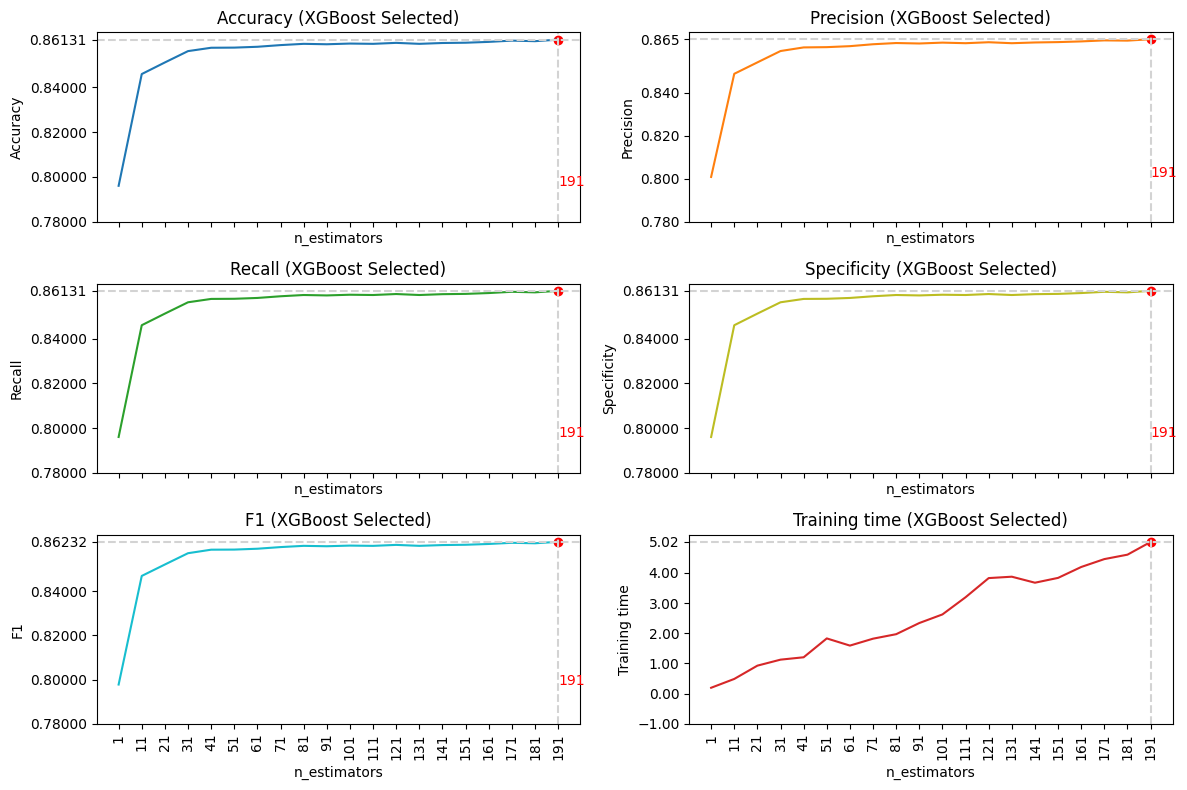

In [78]:
plot_metric(eval_dict, 'XGBoost Selected', 'n_estimators', list_estimators)

This one goes much better than with xgboost, and maybe with more DT it would get even better

In [81]:
important_features = [feature for feature, importance in sorted_features if importance >= 0.02]

In [82]:
important_features

['Duration',
 'Std',
 'syn_count',
 'Covariance',
 'urg_count',
 'Protocol Type',
 'Tot sum',
 'Rate',
 'Variance',
 'Min',
 'Max',
 'flow_duration',
 'rst_count',
 'Tot size',
 'AVG',
 'Header_Length',
 'IAT']

In [83]:
list_estimators = range(1, 200, 10)

In [84]:
eval_dict = {'list_accuracy': [], 
             'list_precision': [], 
             'list_recall': [], 
             'list_specificity': [], 
             'list_f1': [], 
             'list_training_time': []}

In [85]:
X_train_rf_important = df_train[important_features]
X_test_rf_important = df_test[important_features]
X_train_rf_important = standard_scaler.fit_transform(X_train_rf_important)
X_test_rf_important = standard_scaler.transform(X_test_rf_important)

In [86]:
best_accuracy = 0.0

for val in list_estimators:
    # Create classifier instance
    clf = RandomForestClassifier(n_estimators=val, n_jobs=-1, random_state=777)
    
    # Register start time
    t_start = time.time()
    
    # Fit the classifier on the training data
    clf.fit(X_train_rf_important, y_train)
    
    # Register end time
    t_stop = time.time()
    
    # Predict probabilities on the test data
    y_pred = clf.predict(X_test_rf_important)
    
    # Calculate accuracy
    current_accuracy = accuracy_score(y_test, y_pred)
    
    # Save the model if it has the best accuracy so far
    if current_accuracy > best_accuracy:
        best_accuracy = current_accuracy
        dump(clf, 'models/ensemble/RF_best_feature_importance_02.joblib')

    eval_dict['list_accuracy'].append(current_accuracy)
    eval_dict['list_precision'].append(precision_score(y_test, y_pred, average='weighted'))
    eval_dict['list_recall'].append(recall_score(y_test, y_pred, average='weighted'))
    eval_dict['list_specificity'].append(recall_score(y_test, y_pred, pos_label=0, average='weighted'))
    eval_dict['list_f1'].append(f1_score(y_test, y_pred, average='weighted'))
    eval_dict['list_training_time'].append(t_stop - t_start)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_cl

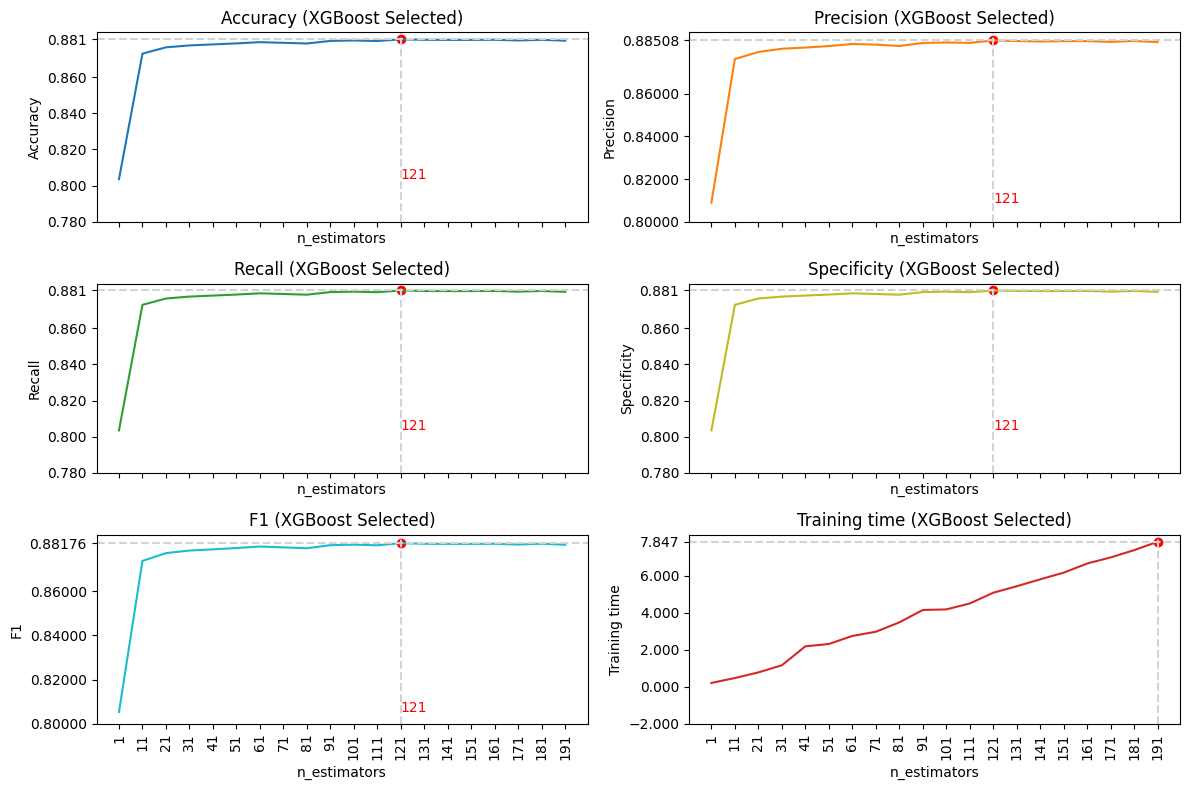

In [87]:
plot_metric(eval_dict, 'XGBoost Selected', 'n_estimators', list_estimators)

We can see that is actually works pretty similar to the one with all the features because some features are not really needed.

# Voting Classifiers

Let's try to see if the predictions that are created by different classifiers are different, so that we can think about a voting classifier

We will consider the following, all with the best paramethers: Decision Trees, Random Forests, XGBoost, since they were the ones that performed best

In [88]:
y_dt = load('models/nonLinear/DT_best.joblib').predict(X_test_final)
y_rf = load('models/ensemble/RF_best.joblib').predict(X_test_final)
y_xgb = load('models/ensemble/xgb_best.joblib').predict(X_test_final)

In [97]:
sum([1 for i, j in zip(y_dt, y_rf) if i != j])

6499

In [98]:
sum([1 for i, j in zip(y_dt, y_xgb) if i != j])

6419

In [99]:
sum([1 for i, j in zip(y_rf, y_xgb) if i != j])

4360

In [100]:
sum([1 for i, j, k in zip(y_rf, y_xgb, y_dt) if i != j != k])

2598

We can see that some of them are definitely different, let's try to create a couple of voting classifiers to check for improvement

We had the best DT with 23 as max_depth\
We had the best RF with 166 estimators\
We had the best XGBoost with 111 estimators

In [102]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

In [109]:
clf = VotingClassifier(estimators=[
    ('DT', DecisionTreeClassifier(max_depth=23, random_state=777)), 
    ('RF', RandomForestClassifier(n_estimators=166, random_state=777)),
    ('xgb', XGBClassifier(n_estimators=111, random_state=777))],
    voting='hard', n_jobs=-1, verbose=1)

In [110]:
clf.fit(X_train, y_train)

[Voting] ....................... (1 of 3) Processing DT, total=   1.0s
[Voting] ...................... (3 of 3) Processing xgb, total=   7.0s
[Voting] ....................... (2 of 3) Processing RF, total=  23.9s


VotingClassifier(estimators=[('DT',
                              DecisionTreeClassifier(max_depth=23,
                                                     random_state=777)),
                             ('RF',
                              RandomForestClassifier(n_estimators=166,
                                                     random_state=777)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=111, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=777, ...))],
                 n_jobs=-1, verbose=1)

In [111]:
dump(clf, 'models/ensemble/voting_hard_best.joblib')

['models/ensemble/voting_hard_best.joblib']

In [112]:
print(classification_report(y_test, clf.predict(X_test), target_names=label2id))

               precision    recall  f1-score   support

BenignTraffic       0.85      0.90      0.87      2036
        Mirai       0.99      0.99      0.99      2035
         DDoS       1.00      0.97      0.98      1973
     Spoofing       0.85      0.82      0.84      1960
          Web       0.73      0.88      0.80      1974
        Recon       0.88      0.77      0.82      2038
   BruteForce       0.84      0.81      0.82      2051
          DoS       1.00      0.98      0.99      1933

     accuracy                           0.89     16000
    macro avg       0.89      0.89      0.89     16000
 weighted avg       0.89      0.89      0.89     16000



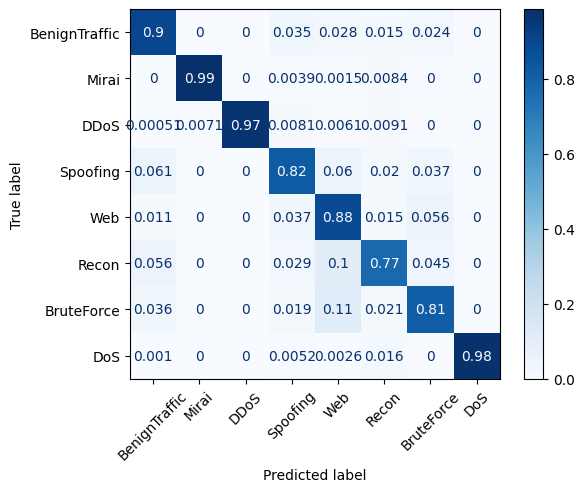

In [113]:
ConfusionMatrixDisplay.from_predictions(y_test, clf.predict(X_test), display_labels=label2id, cmap='Blues', normalize='true', xticks_rotation=45)
plt.show()

In [114]:
clf = VotingClassifier(estimators=[
    ('DT', DecisionTreeClassifier(max_depth=23, random_state=777)), 
    ('RF', RandomForestClassifier(n_estimators=166, random_state=777)),
    ('xgb', XGBClassifier(n_estimators=111, random_state=777))],
    voting='soft', n_jobs=-1, verbose=1)

In [115]:
clf.fit(X_train, y_train)

[Voting] ....................... (1 of 3) Processing DT, total=   1.0s
[Voting] ...................... (3 of 3) Processing xgb, total=   8.2s
[Voting] ....................... (2 of 3) Processing RF, total=  24.1s


VotingClassifier(estimators=[('DT',
                              DecisionTreeClassifier(max_depth=23,
                                                     random_state=777)),
                             ('RF',
                              RandomForestClassifier(n_estimators=166,
                                                     random_state=777)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=111, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=777, ...))],
                 n_jobs=-1, verbose=1, voting='soft')

In [116]:
dump(clf, 'models/ensemble/voting_soft_best.joblib')

['models/ensemble/voting_soft_best.joblib']

In [117]:
print(classification_report(y_test, clf.predict(X_test), target_names=label2id))

               precision    recall  f1-score   support

BenignTraffic       0.86      0.89      0.87      2036
        Mirai       1.00      0.98      0.99      2035
         DDoS       1.00      0.97      0.98      1973
     Spoofing       0.85      0.82      0.83      1960
          Web       0.73      0.87      0.80      1974
        Recon       0.85      0.78      0.81      2038
   BruteForce       0.83      0.81      0.82      2051
          DoS       1.00      0.98      0.99      1933

     accuracy                           0.89     16000
    macro avg       0.89      0.89      0.89     16000
 weighted avg       0.89      0.89      0.89     16000



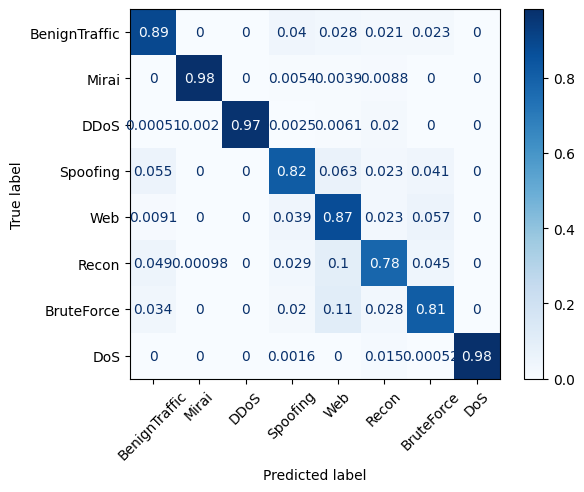

In [118]:
ConfusionMatrixDisplay.from_predictions(y_test, clf.predict(X_test), display_labels=label2id, cmap='Blues', normalize='true', xticks_rotation=45)
plt.show()

the hard one seems a little better at understanding the Benign (on the small test), so we'll use that one

In [119]:
print(classification_report(y_test_final, clf.predict(X_test_final), target_names=label2id))

               precision    recall  f1-score   support

BenignTraffic       0.87      0.88      0.87     10000
        Mirai       1.00      0.99      0.99     10000
         DDoS       1.00      0.96      0.98     10000
     Spoofing       0.87      0.82      0.85     10000
          Web       0.79      0.88      0.83     10000
        Recon       0.87      0.78      0.82     10000
   BruteForce       0.60      0.81      0.69      3064
          DoS       1.00      0.98      0.99     10000

     accuracy                           0.89     73064
    macro avg       0.87      0.89      0.88     73064
 weighted avg       0.90      0.89      0.90     73064



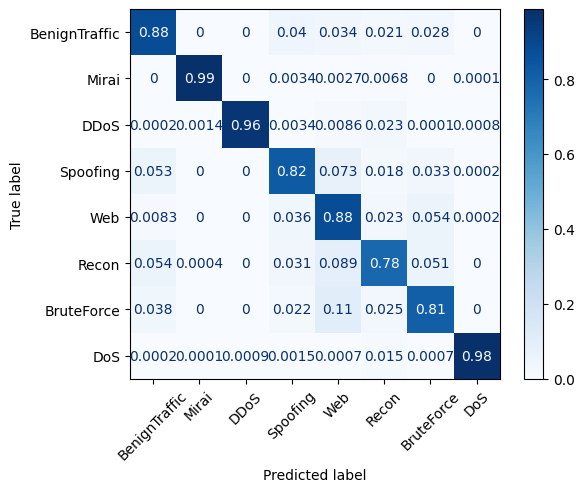

In [120]:
ConfusionMatrixDisplay.from_predictions(y_test_final, clf.predict(X_test_final), display_labels=label2id, cmap='Blues', normalize='true', xticks_rotation=45)
plt.show()

We get a slight increare in performace, without requiring too much time. We are happy that the predictions stay consistent in a larger test dataset.